In [4]:
import pprint
from geopy import Point


class Event:

    def __init__(self):
        pass

    def end_time(self):
        raise NotImplementedError


class Dot(Event):
    """ Represents the location of the ambulance over time."""

    def __init__(self, location, starting_time, duration):
        """

        :param location:
        :param starting_time:
        :param duration:
        """
        self.location = location
        self.starting_time = starting_time
        self.duration = duration
        self.ending_time = starting_time + duration
        self.dots = self.__duration_as_dots()

    def end_time(self):
        return self.ending_time

    def __duration_as_dots(self):
        """ Enumerate over time where the location is"""
        delta = round(self.duration.seconds / 60) + 1
        # if delta < 1: delta = 1

        return [self.location for _ in range(delta)]

    def __str__(self):
        """ For the debuggings """
        return pprint.PrettyPrinter().pformat({
            "location": self.location,
            "starting_time": self.starting_time,
            "duration": self.duration,
            "ending_time": self.ending_time,
            "paths": self.dots  # TODO I know, this is technically a list of the same point.
        })


class Line(Event):
    """ Represents the edge of the ambulance over time. """

    def __init__(self, starting_point, ending_point, starting_time, duration):
        """ Defines the points between the starting point and ending point. """
        self.starting_point = starting_point
        self.ending_point = ending_point
        self.starting_time = starting_time
        self.duration = duration
        self.ending_time = starting_time + duration
        self.dots = self.__duration_as_dots()

    def __duration_as_dots(self):
        """
        Longer distance shown by distance of the line.
        Longer time shown by the number of dots that get drawn before it finishes.
        """

        # Calculate the delta distance as end-start/minutes
        delta = round(self.duration.seconds / 60) + 1
        # if delta < 1: delta = 1
        dist_lat = self.ending_point.latitude - self.starting_point.latitude
        dist_lon = self.ending_point.longitude - self.starting_point.longitude
        d_lat, d_lon = dist_lat / delta, dist_lon / delta

        # List of [minutes] points between start and end
        return [Point(
            self.starting_point.latitude + time_slice * d_lat,
            self.starting_point.longitude + time_slice * d_lon)
            for time_slice in range(delta)]

    def end_time(self):
        return self.ending_time

    def __str__(self):
        """ For the debuggings """
        return pprint.PrettyPrinter().pformat({
            "starting_point": self.starting_point,
            "ending_point": self.ending_point,
            "starting_time": self.starting_time,
            "duration": self.duration,
            'ending_time': self.ending_time,
            'path': self.dots
        })


In [8]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import random


class Animator:
    def __init__(self,
                 start_time,
                 end_time,
                 ambulance_locations,
                 bases,
                 hospitals,
                 ambulance_trips):

        time_delta = (end_time - start_time)
        duration = round(time_delta.seconds / 60) + time_delta.days * 24 * 60
        frames = [[[[], []] for _ in range(len(ambulance_locations))] for _ in range(duration)]

        self.ambulance_locations = ambulance_locations  # This is actually a bit of a misnomer.
        self.bases = bases
        self.hospitals = hospitals

        event_count = 0

        for ambulance in ambulance_trips:
            for trip in ambulance:
                ambulance_id = trip.ambulance_id
                for event in trip.events:
                    index_start = round((event.starting_time - start_time).seconds / 60)
                    xs = [point.longitude for point in event.dots]
                    ys = [point.latitude for point in event.dots]
                    self.set_frames(frames, index_start, ambulance_id, xs, ys)

                    event_count += 1

        for curr_index in range(len(frames)):
            for ambulance_id in range(len(ambulance_locations)):
                # If no position was specified, then it is at base and stationary.
                if not frames[curr_index][ambulance_id][0]:
                    frames[curr_index][ambulance_id][0] += [self.ambulance_locations[ambulance_id].longitude] * 2
                    frames[curr_index][ambulance_id][1] += [self.ambulance_locations[ambulance_id].latitude] * 2
        self.frames = frames
        self.duration = duration

        # Random color generator
        r = lambda: random.randint(0, 226)
        self.ambulance_colors = ['#%02X%02X%02X' % (r(), r(), r()) for _ in range(len(ambulance_locations))]

        if True:
            print('frames: {}\nambs: {}\nevents: {}\n'.format(
                len(self.frames), len(ambulance_locations), event_count
            ))

    def set_frames(self, frames, index_start, ambulance_id, xs, ys, display=10):
        """
        Take the coordinates from the events and enumerate them frame by frame.
        The [display] most recent coordinates are used.
        :param frames:
        :param index_start:
        :param ambulance_id:
        :param xs:
        :param ys:
        :param display:
        :return:
        """

        if not xs: return

        curr_index = index_start
        start_position = 0
        end_position = 1
        last_position = len(xs)

        # Enumerate the historically most recent coordinates.
        while start_position < end_position:

            frames[curr_index][ambulance_id][0] += xs[start_position: end_position]
            frames[curr_index][ambulance_id][1] += ys[start_position: end_position]

            if end_position < last_position:
                end_position += 1

            if end_position - start_position > display or end_position == last_position:
                start_position += 1

            curr_index += 1

    def run_animation(self):
        """ Define a new update function and use it as the update function
         for the matplotlib.  """

        def _get_frame(frame_index, plots):
            """ Should be called by run_animations only. """

            # TODO Using the indices of the self.frames, plot in correct location.
            # Okay right now there is a problem where it's unknown whether the set of coordinates
            # is a line or a dot -- that info got lost up there

            for amb_index in range(len(self.frames[frame_index])):
                xs = self.frames[frame_index][amb_index][0]
                ys = self.frames[frame_index][amb_index][1]

                if len(xs) > 1:
                    if xs[0] == xs[1]:
                        plots[amb_index][1].set_data([xs[0]], [ys[0]])
                    if xs[-2] == xs[-1]:
                        plots[amb_index][1].set_data([xs[-1]], [ys[-1]])

                plots[amb_index][0].set_data(xs, ys)

            print(plots[len(self.ambulance_locations)])

            return plots,

        fig = plt.figure()

        # TODO need [number of ambulances] x [number of states]

        plots = []
        for i in range(len(self.ambulance_locations)):
            new_color = self.ambulance_colors[i]

            line_plot, = plt.plot([], [],
                                  marker='+',
                                  linestyle='',
                                  markerfacecolor=new_color,
                                  markeredgecolor=new_color
                                  )

            dot_plot, = plt.plot([], [],
                                 marker='o',
                                 linestyle='',
                                 markerfacecolor=new_color,
                                 markeredgecolor=new_color
                                 )

            plots.append([line_plot, dot_plot])

        base_plot = plt.scatter([base.longitude for base in self.bases],
                             [base.latitude for base in self.bases],
                             marker="o")
        hospital_plot = plt.scatter([hospital.longitude for hospital in self.hospitals],
                                 [hospital.latitude for hospital in self.hospitals],
                                 marker="s")

        plots.append(base_plot)
        plots.append(hospital_plot)

        # TODO Make boundaries parameters

        img = plt.imread("./simple.png")
        plt.imshow(img, extent=[-117.017637, -117.167672, 32.710484, 32.823033])
        print("draw the animation")
        ani = animation.FuncAnimation(fig, _get_frame, len(self.frames),
                                      fargs=(plots,), interval=50)

        plt.show()

        # fps = 15
        # print('save the animation')
        # print("it may take up to {}".format(len(self.frames)/fps))
        # ani.save('regional_vis6.mp4', fps=fps, dpi=150)


vis starting
frames: 2528
ambs: 5
events: 2500

draw the animation


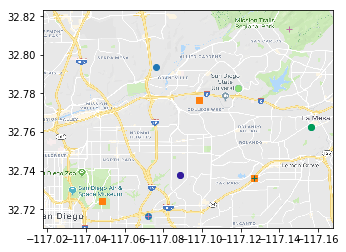

vis ended


In [9]:
# ASSUMPTIONS
# (1a) The average person does NOT want to view a year's worth of simulation.
# (2a) The number of dots in total should be directly proportional to the number of seconds
# (2b) The number of dots visible should be constant to show velocity.
# (3a) There's a fixed number of ambulances

# ALLOWANCES
# (1a) I CAN enumerate every second of the simulation here.
# (2a) num_dots = num_seconds * rate of change
# (2b) It'll probably be 200 or something.
# (3a) Each ambulance can have its own color that it retains for duration of the visualization.

# The Visualizer should:
# Know the total number of seconds of the entire simulation.
# Make a list length num_seconds
# Define a function to convert seconds into dots. We can set the frame rate later.
# Make sure to know what color each ambulance is.


# Start:
# Start time for the ambulance
# Start and end positions, and the time it takes to reach from s to e.

# End:
# Using the start time for the amb, calculate the number of dots to reach the end
# Using the duration and the start time, calculate the new start time. Repeat until
# no more paths to take.

# TODO IF AMBULANCE TRIP IS EMPTY THEN IT IS IN BASE. JUST FILL IN THE BLANKS WITH BASE_LOC


import numpy as np
import pandas as pd
from geopy import Point


class RegionalVisualizer:
    """ Basically a 3d Array: time x ambulances x dot positions.
     This class is the overall visualizer that invokes reading the CSV files,
     processes them into useful data, and runs the matplotlib animations. """

    def __init__(self,
                 cases_file,
                 ambulances_file,
                 bases_file,
                 hospitals_file):
        """

        :param source_file:
        :param ambulance_file:
        """

        # Read the raw data from the CSV files
        raw_data = pd.read_csv(cases_file)
        amb_data = pd.read_csv(ambulances_file)
        base_data = pd.read_csv(bases_file)
        hospital_data = pd.read_csv(hospitals_file)

        # Get the number and starting location of the ambulances
        ambulance_locations = self.__read_points(amb_data, headers=["base_latitude", "base_longitude"])
        bases = self.__read_points(base_data)
        hospitals = self.__read_points(hospital_data)

        self.ambulance_trips = [[] for _ in range(len(ambulance_locations))]
        self.start_time = pd.to_datetime(raw_data.iloc[[0]]['start_time'].values[0])

        # Read each row of the trips. Each row is an ambulance case.
        for index in raw_data.index:
            row = raw_data.iloc[[index]]
            amb_trip = AmbulanceTrip(row, ambulance_locations)
            self.ambulance_trips[amb_trip.ambulance_id].append(amb_trip)

        # Find the end time
        end_time = None
        for trips in self.ambulance_trips:
            if trips:
                last_trip = trips[-1]
                if not end_time or end_time < last_trip.end_time:
                    end_time = last_trip.end_time

        self.end_time = end_time
        self.num_minutes = round((self.end_time - self.start_time).seconds / 60)

        # embed()
        # Call the animator
        a = Animator(self.start_time,
                     self.end_time,
                     ambulance_locations,
                     bases,
                     hospitals,
                     self.ambulance_trips)
        a.run_animation()

        # embed() # TODO

    def __read_points(self, data, headers=None):

        if headers is None:
            headers = ["latitude", "longitude"]

        return [Point(latitude, longitude) for latitude, longitude in zip(data[headers[0]].tolist(),
                                                                          data[headers[1]].tolist())]

    def __str__(self):
        return "\n  ".join(['['] + [str(ambulance_trip) + ',' for ambulance_life in self.ambulance_trips \
                                    for ambulance_trip in ambulance_life]) + "\n]"


def main():
    amb_file = '../examples/simple/ambulances.csv'
    case_file = '../examples/simple/cases.csv'
    base_file = '../examples/simple/bases_subset.csv'
    hospitals_file = '../examples/simple/hospitals.csv'
    r = RegionalVisualizer(case_file, amb_file, base_file, hospitals_file)

    # print(r)


if __name__ == "__main__":
    print("vis starting")
    main()
    print("vis ended")


In [34]:
cases_file = '../../case_records.csv'
raw_data = pd.read_csv(cases_file)

In [35]:
def __read_points(data, headers=None):

    if headers is None:
        headers = ["latitude", "longitude"]

    return [Point(latitude, longitude) for latitude, longitude in zip(data[headers[0]].tolist(),
                                                                      data[headers[1]].tolist())]

In [36]:
case_locations = __read_points(raw_data)

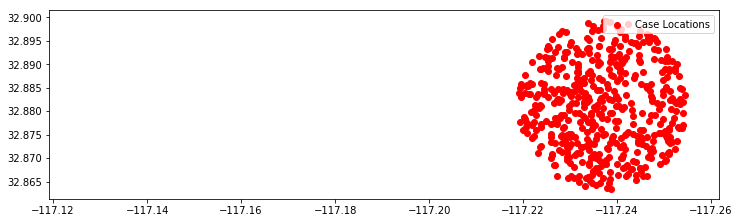

In [52]:
import matplotlib.pyplot as plt
import gmplot

longitudes = [point.longitude for point in case_locations]
latitudes = [point.latitude for point in case_locations]

min_lat = min(latitudes)
max_lat = min(latitudes)
min_long = max(longitudes)
max_long = max(longitudes)

plt.figure(figsize=(12, 10))
img = plt.imread("../../UCSD-map.png")
plt.imshow(img, extent=[min_long, max_long, min_lat, max_lat])
plt.scatter(longitudes, latitudes, color="red", label="Case Locations")
plt.legend(loc="upper right")

plt.show()

In [55]:
# import gmplot package 
import gmplot 
  
longitudes = [point.longitude for point in case_locations]
latitudes = [point.latitude for point in case_locations]


  
gmap3 = gmplot.GoogleMapPlotter(32.880796, 
                                -117.237047, 13) 
  
# scatter method of map object  
# scatter points on the google map 
gmap3.scatter(latitudes, longitudes, '# FF0000', size = 40, marker = False ) 
  
gmap3.draw("./map.html") 